In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv("data/astro.csv", sep=";")
df['Dates'] = pd.to_datetime(df['Dates'], format="mixed")

In [4]:
astro = df.pivot_table(index="Dates", columns="Type", values=["Price", "Size"])

In [7]:
astro.loc[:, ('Price', 'BEST_ASK')] = astro['Price']['BEST_ASK'].ffill()
astro.loc[:, ('Price', 'BEST_BID')] = astro['Price']['BEST_BID'].ffill()
astro.loc[:, ('Size', 'BEST_ASK')] = astro['Size']['BEST_ASK'].ffill()
astro.loc[:, ('Size', 'BEST_BID')] = astro['Size']['BEST_BID'].ffill()

astro.loc[:, ('Price', 'BEST_ASK')] = astro['Price']['BEST_ASK'].replace(0, np.nan)
astro.loc[:, ('Price', 'BEST_BID')] = astro['Price']['BEST_BID'].replace(0, np.nan)
astro.loc[:, ('Size', 'BEST_ASK')] = astro['Size']['BEST_ASK'].replace(0, np.nan)
astro.loc[:, ('Size', 'BEST_BID')] = astro['Size']['BEST_BID'].replace(0, np.nan)

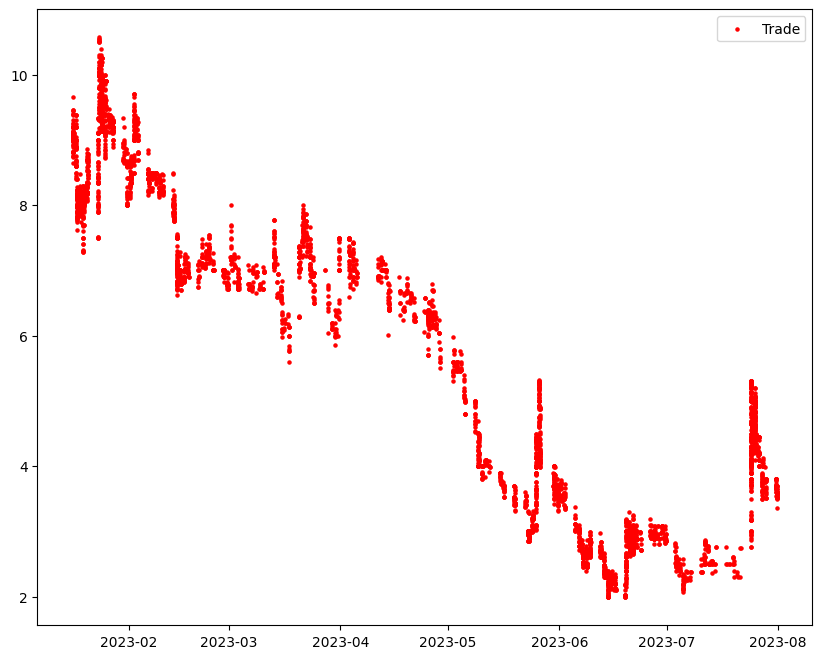

In [8]:
plt.figure(figsize=(10, 8))  # Change the numbers to adjust the size of the plot
plt.scatter(astro.index, astro['Price']['TRADE'], s=5, color='red', label='Trade')  # Plot trades as points
#plt.plot(astro['Price']['BEST_BID'], label='Best Bid')
#plt.plot(astro['Price']['BEST_ASK'], label='Best Ask')
plt.legend()  # Add a legend
plt.show()


In [9]:
astro['Price']['BEST_ASK'][~astro['Price']['BEST_ASK'].isna()]

Dates
2023-01-16 03:00:50    9.66
2023-01-16 08:15:00    9.66
2023-01-16 08:52:46    9.56
2023-01-16 09:00:23    9.66
2023-01-16 09:02:23    9.66
                       ... 
2023-07-31 16:18:37    3.70
2023-07-31 16:20:00    3.70
2023-07-31 16:25:04    3.70
2023-07-31 16:30:00    3.70
2023-07-31 16:45:00    3.70
Name: BEST_ASK, Length: 17063, dtype: float64

In [10]:
price_delta = df[(df['Type'] == "BEST_ASK") & (df['Price'] != 0)]['Price'].pct_change()
price_delta = price_delta[(price_delta!=0)&(~price_delta.isna())]*100

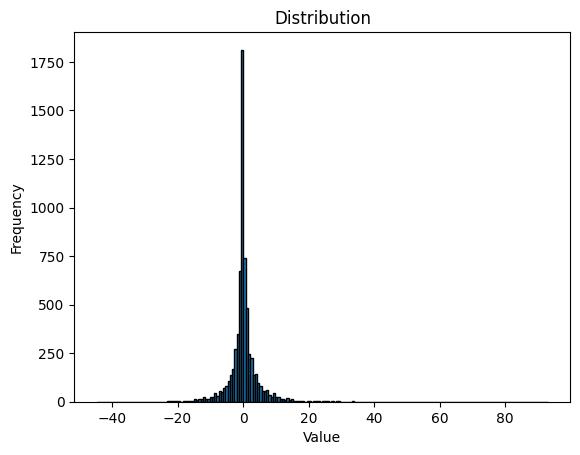

In [11]:
plt.hist(price_delta, bins=200, edgecolor='k')  # You can adjust the number of bins as needed
plt.title('Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Fitting the data to a students t distribution

In [12]:
from scipy.stats import t

# Assuming 'data' is your pandas Series or 1D numpy array
params = t.fit(price_delta)

df, loc, scale = params

print("Degrees of Freedom: ", df)
print("Location: ", loc)
print("Scale: ", scale)

# define the parameters
df = 2.3
loc = 0
scale = 1

# Create the t-distribution
dist = t(df, loc, scale)

# Generate random samples
samples = dist.rvs(size=10000)  # change 1000 to the number of samples you want

Degrees of Freedom:  0.9633987426167537
Location:  -0.2412473579757643
Scale:  0.9966733437464821


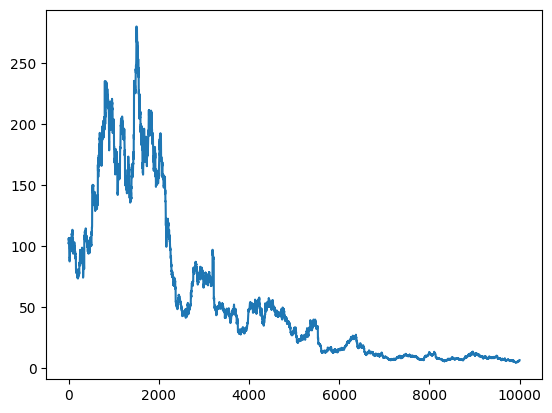

In [13]:
samples = pd.Series(samples)
initial_price = 100  # change to your actual initial price

# Convert percent changes to growth rates and calculate cumulative product
cumulative_price = initial_price * (1 + samples/100).cumprod()

plt.plot(cumulative_price)

In [14]:
import yfinance as yf

In [15]:
asset = "ASTK.CO"
spx = yf.download(asset, start="2010-05-01")

[*********************100%***********************]  1 of 1 completed


In [16]:
night_effect = (spx['Open']/spx['Close'].shift())-0.0/250
spx_return = spx['Close'].pct_change()+1

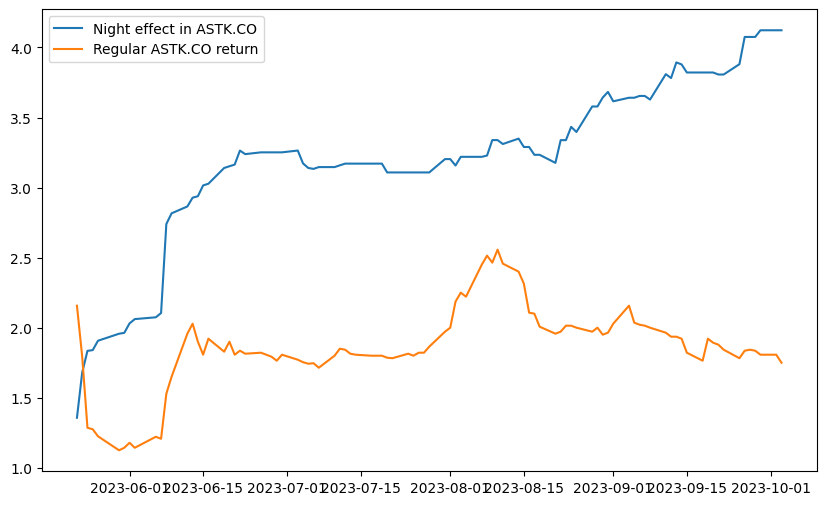

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(night_effect.cumprod(), label=f"Night effect in {asset}")
ax.plot(spx_return.cumprod(), label = f"Regular {asset} return")
ax.legend()
plt.show()

In [18]:
mod_spx_return = (spx_return-1)*0.9+1

In [19]:
def gen_leveraged_return(overnight_leverage=2, yearly_fees = 0.01, spx_leverage=1):
    overnight_leverage -= 1
    returns = (((spx_return-1)*spx_leverage+1)+(night_effect-1)*overnight_leverage-yearly_fees/365)-1
    return returns

In [20]:
def overnight_strat(overnight_leverage=2, yearly_fees = 0.01, spx_leverage=1):
    returns = gen_leveraged_return(overnight_leverage, yearly_fees, spx_leverage)
    strat_sharpe = sharpe(returns)
    return strat_sharpe

In [21]:
def sharpe(in_df):
    std = in_df.std()
    avg_return = in_df.mean()
    yearly_std = std*15.81
    yearly_return = avg_return*250
    sharpe = yearly_return/yearly_std
    #print(f"Return: {yearly_return}, std: {yearly_std}, sharpe: {sharpe}")
    return sharpe

In [22]:
sharpes = []
for i in range(150, 350):
    for j in range(-100, 100):
        shar = overnight_strat(overnight_leverage=i/100, spx_leverage=j/100)
        sharpes.append(shar)

In [ ]:
multiple_sharpes = np.array(sharpes).reshape((200, 200))
# Assuming multiple_sharpes is your 2D numpy array
plt.figure(figsize=(10,8))  # Adjust the size as needed
plt.imshow(multiple_sharpes, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [1136]:
overnight_2x = gen_leveraged_return(2)
overnight_1_5x = gen_leveraged_return(1.7, spx_leverage=0.8, yearly_fees=0)
spy = spx_return -1

In [1137]:
strats = [overnight_2x, overnight_1_5x, spy]
for strat in strats:
    print(sharpe(strat))

1.4913579693263017
1.439236082311526
0.5683227349766873


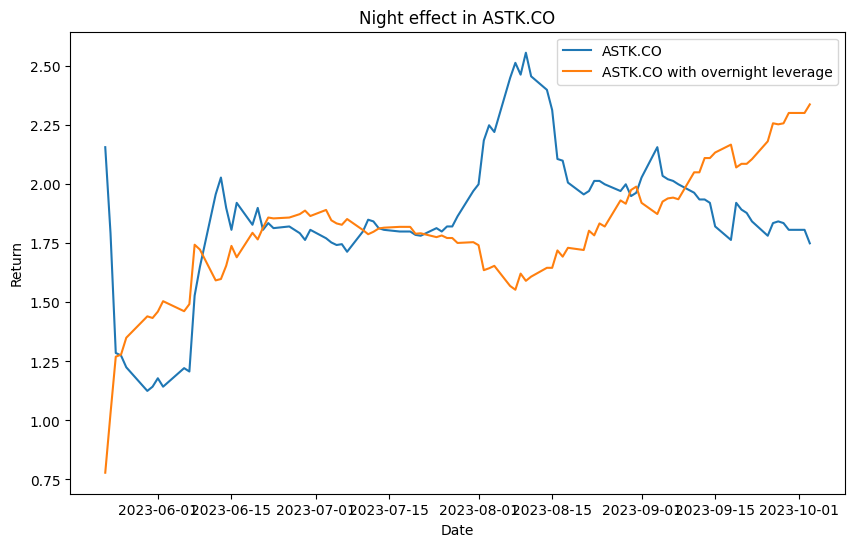

In [23]:
plt.figure(figsize=(10, 6))

# Plotting the normalized SPX close prices
plt.plot(spx_return.cumprod(), label=asset)

# Plotting the cumulative product of the adjusted returns
plt.plot((gen_leveraged_return(overnight_leverage=2, spx_leverage=-0.5)+1).cumprod(), label=f'{asset} with overnight leverage')

# Adding labels and title
plt.title(f'Night effect in {asset}')
plt.xlabel('Date')
plt.ylabel('Return')

# Adding a legend
plt.legend()

plt.show()

In [926]:
gen_leveraged_return(overnight_leverage=2, spx_leverage=0.8)+1

Date
2016-03-21         NaN
2016-03-22    0.972173
2016-03-23    0.971737
2016-03-24    1.007144
2016-03-29    0.971401
                ...   
2023-07-27    0.999973
2023-07-28    0.999973
2023-07-31    0.999973
2023-08-01    0.999973
2023-08-02    0.999973
Length: 1874, dtype: float64

### Systematic night effect screening

In [47]:
tickers = pd.read_csv("data/tickers.csv", sep=";", dtype={'Price (Intraday)':float, 'Volume': str, 'Avg Vol (3 month)':str,'Market Cap': str, 'PE Ratio (TTM)': float})

In [25]:
def parse_millions_and_billions(value):
    value = str(value)
    if 'M' in value:
        return float(value.replace('M', '')) * 1e6
    elif 'B' in value:
        return float(value.replace('B', '')) * 1e9
    else:
        return float(value)

In [26]:
# Apply the function to the columns as needed
tickers['Volume'] = tickers['Volume'].apply(parse_millions_and_billions)
tickers['Avg Vol (3 month)'] = tickers['Avg Vol (3 month)'].apply(parse_millions_and_billions)
tickers['Market Cap'] = tickers['Market Cap'].apply(parse_millions_and_billions)

In [27]:
tickers = tickers[(tickers['Market Cap']<=2e+9)&(tickers['Market Cap']>=1e+7)]

In [28]:
start = '2010-01-01'
end = '2023-08-02'
stocks = yf.download(tickers=tickers['Symbol'].to_list(), start=start, end=end)

[*********************100%***********************]  455 of 455 completed


1 Failed download:
['NOSA.ST']: Exception("%ticker%: Data doesn't exist for startDate = 1262300400, endDate = 1690927200")


In [29]:
group_counts = stocks.groupby(level=0)['Adj Close'].count()
stocks_to_keep = group_counts[group_counts > 500].index
filtered_stocks = stocks.loc[stocks_to_keep]

In [30]:
filtered_stocks

Adj Close                                                  \
                4C.ST      AAB.CO AAC.ST   ABLI.ST ACARIX.ST ACAST.ST   
Date                                                                    
2010-01-04        NaN  651.454834    NaN  7.050655       NaN      NaN   
2010-01-05        NaN  673.170044    NaN  7.516264       NaN      NaN   
2010-01-06        NaN  678.598816    NaN       NaN       NaN      NaN   
2010-01-07        NaN  624.310913    NaN  9.711280       NaN      NaN   
2010-01-08        NaN  651.454834    NaN  8.979608       NaN      NaN   
...               ...         ...    ...       ...       ...      ...   
2023-07-26  26.950001   42.799999  0.563  0.241000    0.4935     7.12   
2023-07-27  27.000000   42.200001  0.590  0.249500    0.4965     7.09   
2023-07-28  26.799999   43.400002  0.605  0.244000    0.5080     7.15   
2023-07-31  27.000000   44.599998  0.685  0.236500    0.5000     7.34   
2023-08-01  26.950001   44.799999  0.653  0.248500    0.5120     7.36   

                                                    ...  Volume          \
             ACCON.ST     ACE.ST ACOU.ST ACRI-A.ST  ... WISE.ST  WMA.CO   
Date                                                ...                   
2010-01-04        NaN        NaN     NaN       NaN  ...   235.0     NaN   
2010-01-05        NaN        NaN     NaN       NaN  ...   500.0     NaN   
2010-01-06        NaN        NaN     NaN       NaN  ...     NaN     NaN   
2010-01-07        NaN        NaN     NaN       NaN  ...  2325.0     NaN   
2010-01-08        NaN        NaN     NaN       NaN  ...  2750.0     NaN   
...               ...        ...     ...       ...  ...     ...     ...   
2023-07-26  26.500000  15.980000   14.45       8.2  ...  2756.0  7232.0   
2023-07-27  26.650000  16.100000   14.50       8.2  ...  7206.0     0.0   
2023-07-28  26.049999  16.160000   14.90       8.1  ...  2900.0     0.0   
2023-07-31  25.900000  16.379999   15.05       8.1  ...  1925.0  6288.0   
2023-08-01  25.450001  16.360001   15.15       8.1  ...  1476.0  4070.0   

                                                                       \
             WYLD.ST XSPRAY.ST YIELD.ST YOYO.CO   ZICC.ST ZORDIX-B.ST   
Date                                                                    
2010-01-04       NaN       NaN      NaN     NaN       NaN         NaN   
2010-01-05       NaN       NaN      NaN     NaN       NaN         NaN   
2010-01-06       NaN       NaN      NaN     NaN       NaN         NaN   
2010-01-07       NaN       NaN      NaN     NaN       NaN         NaN   
2010-01-08       NaN       NaN      NaN     NaN       NaN         NaN   
...              ...       ...      ...     ...       ...         ...   
2023-07-26   50397.0   13556.0   9497.0  2903.0  142268.0      3765.0   
2023-07-27  120352.0   11025.0   8003.0   837.0   75948.0      3895.0   
2023-07-28   66795.0   13805.0   4811.0   853.0   43387.0     14488.0   
2023-07-31   30500.0    8494.0   7168.0  1812.0   33573.0     29930.0   
2023-08-01   83510.0   13168.0   4098.0  2886.0   21843.0      6076.0   

                              
           ZWIPE.ST  ZZ-B.ST  
Date                          
2010-01-04      NaN      NaN  
2010-01-05      NaN      NaN  
2010-01-06      NaN      NaN  
2010-01-07      NaN      NaN  
2010-01-08      NaN      NaN  
...             ...      ...  
2023-07-26   9056.0  11030.0  
2023-07-27  16762.0   5086.0  
2023-07-28   5242.0   3118.0  
2023-07-31  55813.0   4010.0  
2023-08-01  30136.0  15217.0  

[3453 rows x 2730 columns]

In [31]:
novo = yf.download('NOVO-B.CO', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [32]:
night_effect = (stocks['Open']/stocks['Close'].shift())

In [33]:
reg_effect = stocks['Close']/stocks['Close'].shift()

In [34]:
alpha = night_effect-reg_effect

In [35]:
gross_overnight_return = alpha.add(1).cumprod()

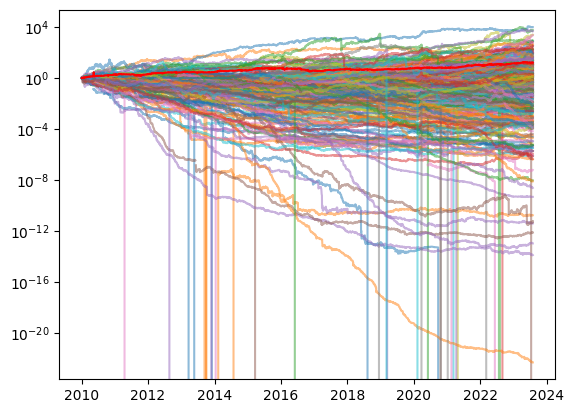

In [36]:
plt.plot(gross_overnight_return, alpha=0.5)
plt.plot(novo['Close']/novo['Close'].iloc[0], c='red')
plt.yscale('log')

In [37]:
plt.plot(alpha.mean(axis=1).add(1).cumprod()[:'2023-01-01'])
plt.plot((novo['Close']/novo['Close'].iloc[0])[:'2023-01-01'], c='red')

TypeError: '<' not supported between instances of 'Timestamp' and 'str'

In [38]:
best_stocks = gross_overnight_return.loc['2023-08-01'].sort_values(ascending=False).index

KeyError: '2023-08-01'

In [ ]:
ordered_tickers = tickers.set_index("Symbol").reindex(best_stocks)
best_tickers = ordered_tickers[:20]
worst_tickers = ordered_tickers[-20:]

In [39]:
worst_returns = reg_effect.loc[:, worst_tickers.index.values].subtract(1)

NameError: name 'worst_tickers' is not defined

In [40]:
plt.hist(worst_returns[worst_returns.columns[0]].values, bins=200, edgecolor='k', range=(-0.05, .05))
#plt.hist(worst_returns["CHR.CO"].values, bins=200, edgecolor='r') # You can adjust the number of bins as needed

NameError: name 'worst_returns' is not defined

In [41]:
best_tickers['Market Cap'].median()/worst_tickers['Market Cap'].median()

NameError: name 'best_tickers' is not defined

In [42]:
plt.hist(worst_tickers['Market Cap'], bins=10)
plt.hist(best_tickers['Market Cap'])

NameError: name 'worst_tickers' is not defined

### Testing the correlation between sharpe ratio and market cap/volume

In [1706]:
night_effect_returns = night_effect.subtract(1).multiply(100)

In [1707]:
night_effect_sharpe = pd.DataFrame((night_effect_returns.mean()*250)/(night_effect_returns.std()*15.8), columns=["sharpe"])

In [1708]:
night_effect_sharpe['mcap'] = tickers.set_index('Symbol')['Market Cap']
night_effect_sharpe['volume'] = tickers.set_index('Symbol')['Volume']
night_effect_sharpe['avg_volume'] = tickers.set_index('Symbol')['Avg Vol (3 month)']

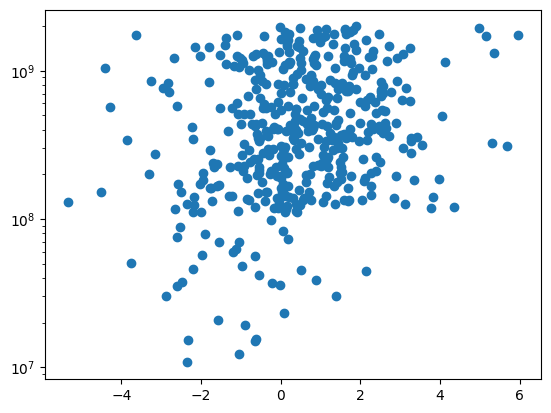

In [1709]:
plt.scatter(x=night_effect_sharpe['sharpe'], y=night_effect_sharpe['mcap'])
plt.yscale('log')

### What does the best strategy look like?

In [1789]:
best_sharpe = night_effect_sharpe.sort_values("sharpe", ascending=False)[0:-100]

In [1790]:
best_sharpe.mean()

sharpe        1.073056e+00
mcap          6.134233e+08
volume        1.941997e+05
avg_volume    2.243819e+05
dtype: float64

In [1813]:
alpha.mean().sort_values(ascending=False)

ASTK.CO        0.017546
DSNO.ST        0.011763
AGTIRA-B.ST    0.009591
GREENH.CO      0.008996
HEXI.ST        0.008372
                 ...   
DIGIZ.CO      -0.009910
NORD.CO       -0.010169
NEXCOM.CO     -0.013671
PARKST-A.CO   -0.013730
TGAMES.CO     -0.015051
Length: 455, dtype: float64

In [1791]:
night_effect_returns.loc[:, best_sharpe.index.values].divide(100).add(1).mean(axis=1).cumprod()

Date
2010-01-04          NaN
2010-01-05     1.009492
2010-01-06     1.014239
2010-01-07     1.015424
2010-01-08     1.019423
                ...    
2023-07-26    30.705530
2023-07-27    30.795144
2023-07-28    30.749897
2023-07-31    30.820787
2023-08-01    30.847689
Length: 3453, dtype: float64

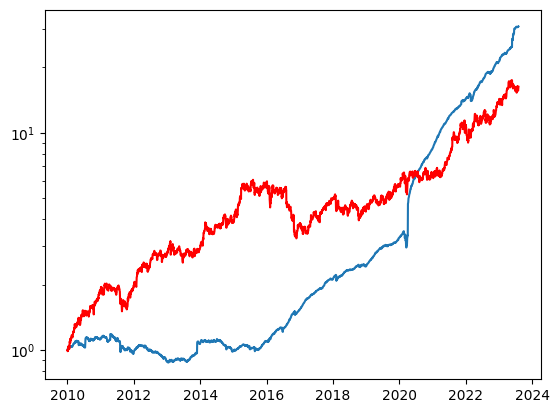

In [1794]:
plt.plot(night_effect_returns.loc[:, best_sharpe.index.values].divide(100).add(1).mean(axis=1).cumprod())
plt.plot((novo['Close']/novo['Close'].iloc[0]), c='red')
plt.yscale('log')

In [1754]:
best_sharpe

sharpe          mcap    volume  avg_volume
LUMEN.ST     5.971000  1.741000e+09    4527.0     17743.0
HEXI.ST      5.671386  3.114150e+08  227693.0   1173000.0
W5.ST        5.347216  1.321000e+09   31113.0     39918.0
ASTK.CO      5.309888  3.258890e+08  400727.0    450404.0
NORB-B.ST    5.152392  1.717000e+09   23322.0     60453.0
...               ...           ...       ...         ...
CASE.ST     -3.854448  3.379250e+08     499.0       822.0
PARKST-A.CO -4.288475  5.650090e+08     155.0       648.0
ONEF.ST     -4.406747  1.043000e+09     571.0      2165.0
CEDER.ST    -4.505854  1.507900e+08    1000.0      1934.0
TGAMES.CO   -5.353786  1.306580e+08    6454.0      8623.0

[455 rows x 4 columns]

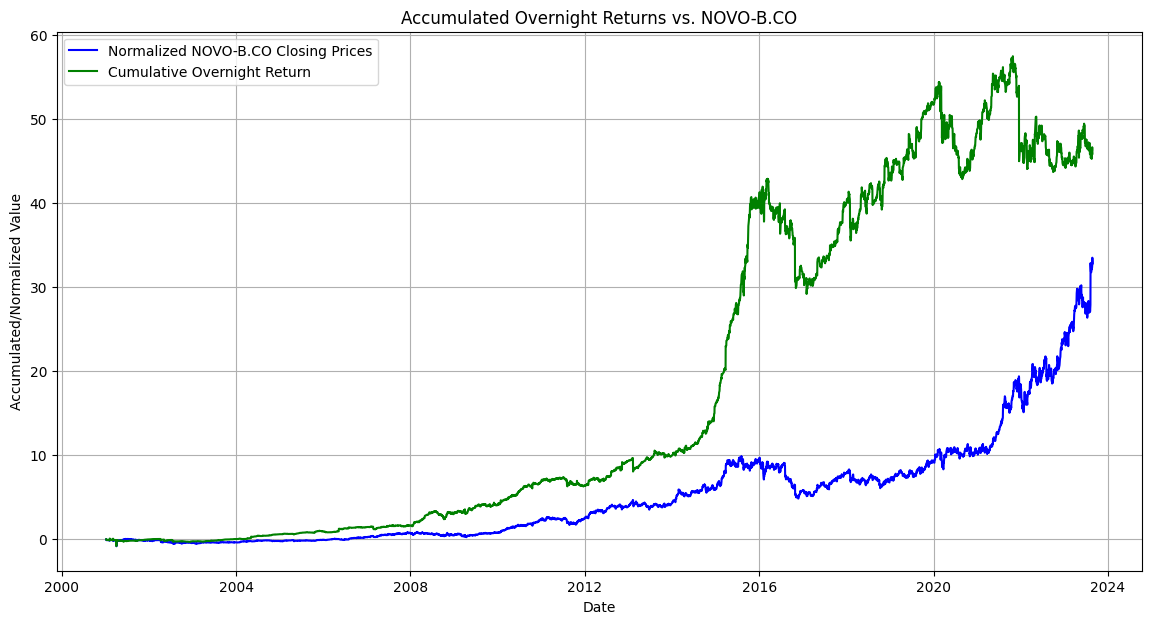

In [101]:
import yfinance as yf
import matplotlib.pyplot as plt

# Define the ticker you want to analyze
ticker = "NOVO-B.CO"

def analyze_ticker(ticker, start_date='2000-01-01'):
    data = yf.download(ticker, start=start_date, progress=False)
    data['Daily_Return'] = (data['Close'] - data['Open']) / data['Open']
    data['Overnight_Return'] = (data['Open'].shift(-1) - data['Close']) / data['Close']
    data[f'Normalized_{ticker}'] = data['Close'] / data['Close'].iloc[0] - 1
    data['Cumulative_Overnight_Return'] = (1 + data['Overnight_Return']).cumprod() - 1
    return data

def plot_data(data, ticker):
    plt.figure(figsize=(14,7))
    plt.plot(data[f'Normalized_{ticker}'], label=f'Normalized {ticker} Closing Prices', color='blue')
    plt.plot(data['Cumulative_Overnight_Return'], label='Cumulative Overnight Return', color='green')
    plt.title(f'Accumulated Overnight Returns vs. {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Accumulated/Normalized Value')
    plt.legend()
    #plt.gca().set_yscale('log')  # This sets the y-axis to a logarithmic scale
    plt.grid(True)
    plt.show()

# Analyze and plot for the defined ticker
data_for_ticker = analyze_ticker(ticker)
plot_data(data_for_ticker, ticker)


### Test it systematically

In [43]:
import yfinance as yf
import numpy as np
import os
import pandas as pd

def find_data(ticker):
    file_name = f"data/{ticker}_data.csv"
    
    # If data is cached (exists in a local CSV), read from it
    if os.path.exists(file_name):
        data = pd.read_csv(file_name, index_col=0, parse_dates=True)
    else:
        # Otherwise, download the data and save to a local CSV
        data = yf.download(ticker, start='2000-01-01', progress=False)
        data.to_csv(file_name)
    return data
    
def accumulated_returns(ticker):
    data = find_data(ticker)
    # Calculate returns
    data['Overnight_Return'] = (data['Open'].shift(-1) - data['Close']) / data['Close']
    data['Daily_Return'] = (data['Close'] - data['Open']) / data['Open']
    data['Agg_overnight_return'] = data['Overnight_Return'].add(1).cumprod()
    
    # Calculate cumulative returns series
    data['Cumulative_Overnight_Return'] = (1 + data['Overnight_Return']).cumprod() - 1
    data['Cumulative_Daily_Return'] = (1 + data['Daily_Return']).cumprod() - 1
    
    return data[['Cumulative_Overnight_Return', 'Cumulative_Daily_Return']]


def analyze_ticker(ticker):
    data = find_data(ticker)

    # Calculate returns
    data['Overnight_Return'] = (data['Open'].shift(-1) - data['Close']) / data['Close']
    data['Daily_Return'] = (data['Close'] - data['Open']) / data['Open']
    data['Agg_overnight_return'] = data['Overnight_Return'].add(1).cumprod()
    
    # Calculate Sharpe ratios
    results = {}
    for return_type in ['Overnight_Return', 'Daily_Return']:
        annual_return = ((1 + data[return_type].mean()) ** 252) - 1  # 252 trading days in a year
        annual_std_dev = data[return_type].std() * np.sqrt(252)
        sharpe_ratio = annual_return / annual_std_dev
        results[return_type] = sharpe_ratio
    
    return results, data

In [44]:
tickers = [
    "ACIU", "ADAP", "AFMD", "ARBK", "ARQQ", "ASPS", "ATAI", "AURC", 
    "AURCU", "CDRO", "CLLS", "CPLP", "DBVT", "DKDCA", "DLNG", "EDAP", 
    "ESEA", "GAN", "GASS", "GNFT", "GNTA", "IFRX", "IMTXW", "IOBT", 
    "IPHA", "IVA", "KNOP", "LILMW", "MDXH", "MOLN", "MREO", "MYNA", 
    "NTZ", "NYXH", "OCSAW", "PRQR", "PXSAP", "RNLX", "RNWWW", "SHIP", 
    "SLN", "SLNA", "SOPH", "SQNS", "TLSA", "TORO", "VACC"
]

all_results = []

for ticker in tickers:
    metrics, returns = analyze_ticker(ticker)
    overnight_sharpe = metrics['Overnight_Return']
    daily_sharpe = metrics['Daily_Return']
    print(f"{ticker: <10} Overnight Sharpe: {overnight_sharpe: >12.4f} | Daily Sharpe: {daily_sharpe: >12.4f}")
    all_results.append([ticker, overnight_sharpe, daily_sharpe])

ACIU       Overnight Sharpe:       1.2099 | Daily Sharpe:      -0.3938
ADAP       Overnight Sharpe:       1.6852 | Daily Sharpe:      -0.5684
AFMD       Overnight Sharpe:       1.8017 | Daily Sharpe:      -0.6324
ARBK       Overnight Sharpe:      -0.0554 | Daily Sharpe:      -0.3088
ARQQ       Overnight Sharpe:       1.0251 | Daily Sharpe:      -0.3665
ASPS       Overnight Sharpe:       0.7539 | Daily Sharpe:       0.0406
ATAI       Overnight Sharpe:       3.9560 | Daily Sharpe:      -1.1400
AURC       Overnight Sharpe:       0.1179 | Daily Sharpe:       0.9877
AURCU      Overnight Sharpe:      -0.2273 | Daily Sharpe:       1.7205
CDRO       Overnight Sharpe:      -0.3834 | Daily Sharpe:       0.3978
CLLS       Overnight Sharpe:       0.6336 | Daily Sharpe:      -0.5791
CPLP       Overnight Sharpe:       0.6164 | Daily Sharpe:      -0.4094
DBVT       Overnight Sharpe:       0.4843 | Daily Sharpe:      -0.3226
DKDCA      Overnight Sharpe:       0.8154 | Daily Sharpe:       0.9608
DLNG  

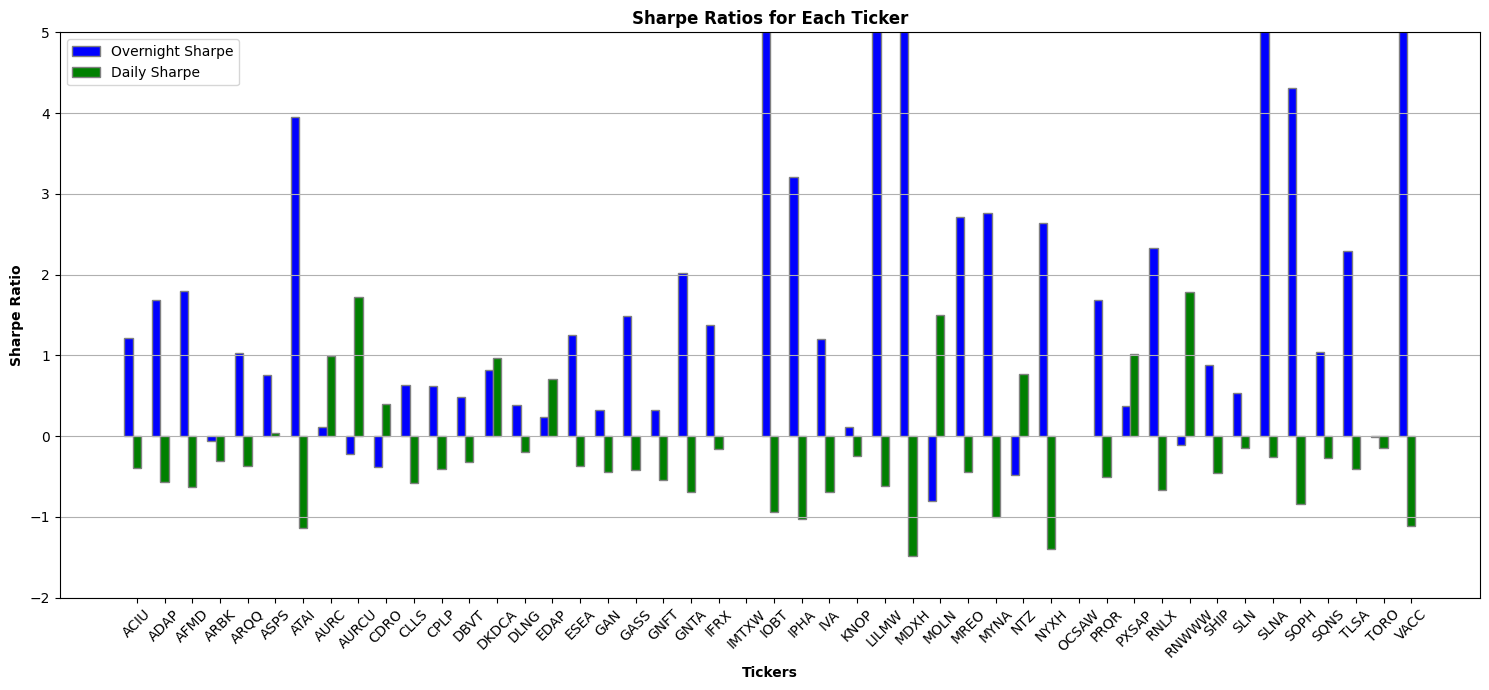

In [45]:
import matplotlib.pyplot as plt

# Assuming all_results is populated
# all_results = [...] 

# Extract tickers, overnight, and daily Sharpe ratios from all_results
tickers = [result[0] for result in all_results]
overnight_sharpes = [result[1] for result in all_results]
daily_sharpes = [result[2] for result in all_results]

# Set the width of the bars
barWidth = 0.3
r1 = range(len(overnight_sharpes))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(15,7))

# Create bars
plt.bar(r1, overnight_sharpes, width=barWidth, color='blue', edgecolor='grey', label='Overnight Sharpe')
plt.bar(r2, daily_sharpes, width=barWidth, color='green', edgecolor='grey', label='Daily Sharpe')

# Title & Subtitle
plt.title('Sharpe Ratios for Each Ticker', fontweight='bold')
plt.xlabel('Tickers', fontweight='bold')
plt.ylabel('Sharpe Ratio', fontweight='bold')

#to log scale
plt.ylim(-2, 5)

# X axis
plt.xticks([r + barWidth for r in range(len(overnight_sharpes))], tickers, rotation=45)

# Create legend & Show graphic
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

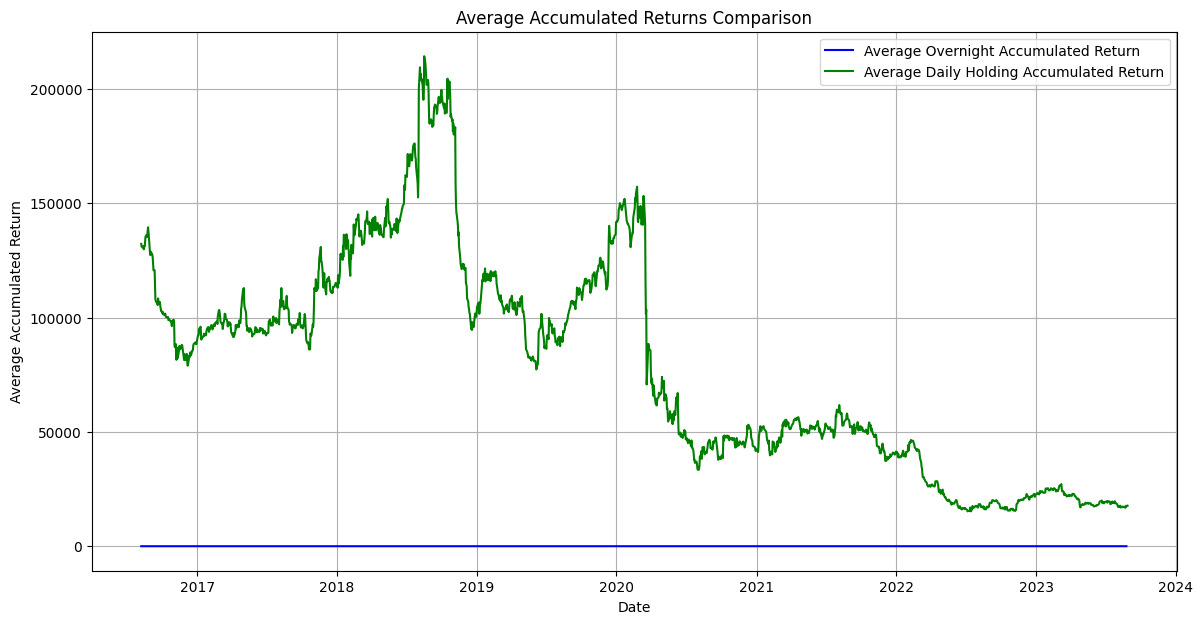

In [46]:
#tickers = [         # European small and micro cap healthcare stocks
#    "ACIU", "ADAP", "AFMD", "ALVOW", "AMRN", "ATAI", "AUTL", "AVDL", 
#    "BCYC", "CALT", "CLLS", "CMPS", "CNTA", "DBVT", "DKDCA", "EDAP", 
#    "EXAI", "GHRS", "GMAB", "GNFT", "GNTA", "IFRX", "IMTX", "IMTXW"
#]

tickers = [            # European and NA micro cap tech stocks
    "AEYE", "AIP", "AKLI", "ALOT", "ARQQ", "ASUR", "ASYS", "ATLX", "ATOM", 
    "AUGX", "AUID", "AVPTW", "AXTI", "BCOV", "BEAT", "BEEM", "BEEMW", "BKSY", 
    "BLND", "BLZE", "BRAG", "CASA", "CLMB", "CMAX", "CMTL", "CPSI", "CSPI", 
    "CTG", "CXAI", "DAVE", "DFLI", "DWACW", "EGAN", "EMAN", "EVER", "EVLVW", 
    "FNGR", "FORA", "FTCI", "GAN", "GEG", "GMGI", "GROMW", "GSIT", "HLTH", 
    "IMMR", "INDIW", "INTT", "INVE", "IPWR", "ISSC", "IVAC", "KLR", "KLTR", 
    "KOPN", "KULR", "KVHI", "LIFW", "LINK", "LPSN", "LPTH", "MKFG", "ML", 
    "MLGO", "MMAT", "MNTX", "MRAM", "MULN", "NUTX", "OUST", "PAYOW", "PCTI", 
    "PCYG", "PET", "POET", "PRCH", "PRST", "PXLW", "QMCO", "QUBT", "QUIK", 
    "RDVT", "RELL", "RMBL", "SHCR", "SKIL", "SKYT", "SLNHP", "SMSI", "SNCR", 
    "SNCRL", "SOTK", "SOUNW", "SQNS", "SSTI", "STIX", "STRM", "TACT", "TCX", 
    "TGAN", "TLS", "TRUE", "TWOU", "UIS", "UPLD", "VCSA", "VERI", "VOXX", 
    "VUZI", "WFCF", "WGS", "ZFOX"
]

import random

tickers = random.sample(tickers, 20)

# Create DataFrames to store average accumulated returns for each date
avg_cumulative_overnight = pd.DataFrame()
avg_cumulative_daily = pd.DataFrame()

for ticker in tickers:
    data = accumulated_returns(ticker)
    avg_cumulative_overnight[ticker] = data['Cumulative_Overnight_Return']
    avg_cumulative_daily[ticker] = data['Cumulative_Daily_Return']

# Compute average across tickers for each date
avg_cumulative_overnight['Average'] = avg_cumulative_overnight.mean(axis=1)
avg_cumulative_daily['Average'] = avg_cumulative_daily.mean(axis=1)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(avg_cumulative_overnight['Average'], label="Average Overnight Accumulated Return", color="blue")
plt.plot(avg_cumulative_daily['Average'], label="Average Daily Holding Accumulated Return", color="green")
plt.title("Average Accumulated Returns Comparison")
plt.xlabel("Date")
plt.ylabel("Average Accumulated Return")
#plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()